In [1]:
import numpy as np
from CART import RegressionTree
from Utils.plotting import  *
from Utils.simulation_helpers import *

In [11]:
def root_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100):
    pivots = []
    naive_pivots = []
    for i in range(start, end):
        print(i, "th simulation")
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=10, max_depth=5,
                                  min_proportion=0.2)
        reg_tree.fit(X, y, sd = noise_sd)
        
        #if not reg_tree.root.left.left:
        #    continue
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
        reg_tree.condl_split_inference(node=reg_tree.root, 
                                       ngrid=10000,
                                       ncoarse=200,
                                       grid_width=15,
                                       reduced_dim=1,
                                       sd=sd_y))
        
        target = norm_contrast.dot(mu)
        pivot_i = dist.ccdf(theta=target, x=obs_tar)
        pivots.append(pivot_i)
        
        naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                             null=target)
        naive_pivots.append(naive_pivot)
    
    return pivots, naive_pivots

In [12]:
pivots_50, naive_pivots_50 \
    = root_inference_sim(start=0, end=200, n=50,
                         sd_y=3, noise_sd=2, 
                         a=1,b=1)

0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation
14 th simulation
15 th simulation
16 th simulation
17 th simulation
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
24 th simulation
25 th simulation
26 th simulation
27 th simulation
28 th simulation
29 th simulation
30 th simulation
31 th simulation
32 th simulation
33 th simulation
34 th simulation
35 th simulation
36 th simulation
37 th simulation
38 th simulation
39 th simulation
40 th simulation
41 th simulation
42 th simulation
43 th simulation
44 th simulation
45 th simulation
46 th simulation
47 th simulation
48 th simulation
49 th simulation
50 th simulation
51 th simulation
52 th simulation
53 th simulation
54 th simulation
55 th simulation
56 th simulation
57 th simulation
58 th simulation
59 th s

In [17]:
pivots_50pp, naive_pivots_50pp \
    = root_inference_sim(start=200, end=500, n=50,
                         sd_y=3, noise_sd=2, 
                         a=1,b=1)

200 th simulation
201 th simulation
202 th simulation
203 th simulation
204 th simulation
205 th simulation
206 th simulation
207 th simulation
208 th simulation
209 th simulation
210 th simulation
211 th simulation
212 th simulation
213 th simulation
214 th simulation
215 th simulation
216 th simulation
217 th simulation
218 th simulation
219 th simulation
220 th simulation
221 th simulation
222 th simulation
223 th simulation
224 th simulation
225 th simulation
226 th simulation
227 th simulation
228 th simulation
229 th simulation
230 th simulation
231 th simulation
232 th simulation
233 th simulation
234 th simulation
235 th simulation
236 th simulation
237 th simulation
238 th simulation
239 th simulation
240 th simulation
241 th simulation
242 th simulation
243 th simulation
244 th simulation
245 th simulation
246 th simulation
247 th simulation
248 th simulation
249 th simulation
250 th simulation
251 th simulation
252 th simulation
253 th simulation
254 th simulation
255 th sim

In [18]:
pivots_50 = pivots_50 + pivots_50pp
naive_pivots_50 = naive_pivots_50 + naive_pivots_50pp

(array([37., 43., 43., 50., 70., 59., 58., 55., 43., 42.]),
 array([6.17501172e-04, 1.00517926e-01, 2.00418351e-01, 3.00318776e-01,
        4.00219201e-01, 5.00119627e-01, 6.00020052e-01, 6.99920477e-01,
        7.99820902e-01, 8.99721327e-01, 9.99621752e-01]),
 <BarContainer object of 10 artists>)

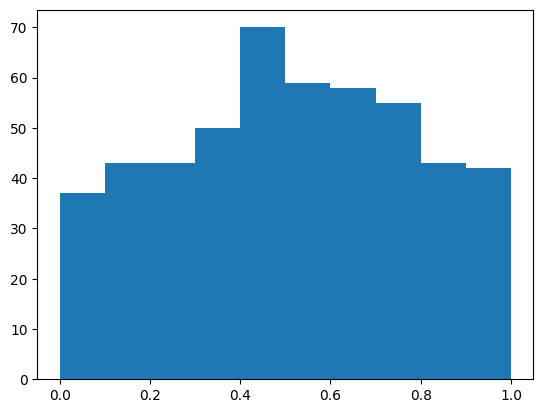

In [20]:
plt.hist(pivots_50, bins=10)

(array([216.,  75.,  50.,  30.,  14.,   9.,   5.,   2.,   4.,  95.]),
 array([2.38274426e-06, 1.00000430e-01, 1.99998477e-01, 2.99996524e-01,
        3.99994571e-01, 4.99992618e-01, 5.99990666e-01, 6.99988713e-01,
        7.99986760e-01, 8.99984807e-01, 9.99982854e-01]),
 <BarContainer object of 10 artists>)

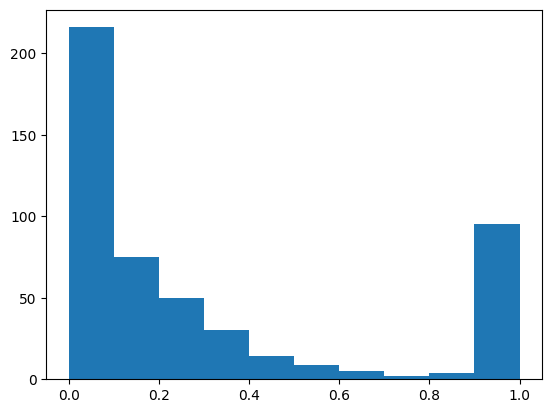

In [21]:
plt.hist(naive_pivots_50, bins=10)

In [25]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ecdfs(data_list, labels, title=None):
    # Step 2: Sort the data
    sorted_data = []
    for data in data_list:
        data_sorted = np.sort(data)
        sorted_data.append(data_sorted)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    for i, data in enumerate(sorted_data):
        plt.step(data, cdf_values, where='post', 
                 label=labels[i])
    if not title:
        plt.title('Empirical Cumulative Distribution Function')
    else:
        plt.title(title)
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()


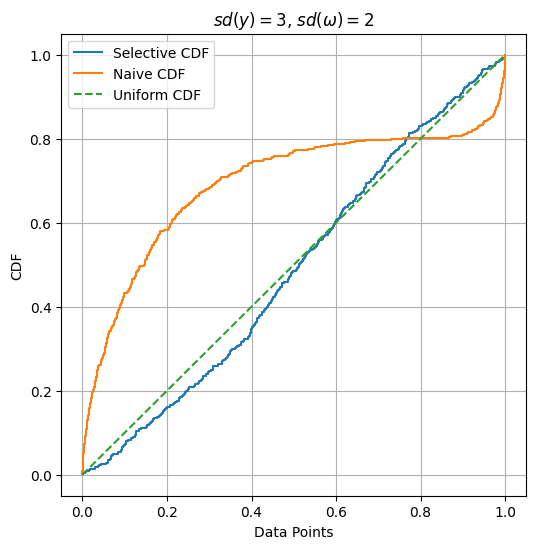

In [26]:
plot_ecdfs([pivots_50, naive_pivots_50], ["Selective CDF", "Naive CDF"],
           title="$sd(y)=3$, $sd(\omega) = 2$")

In [56]:
len(pivots_50)

100

In [46]:
unif = np.random.uniform(low=0, high=1, size=50)

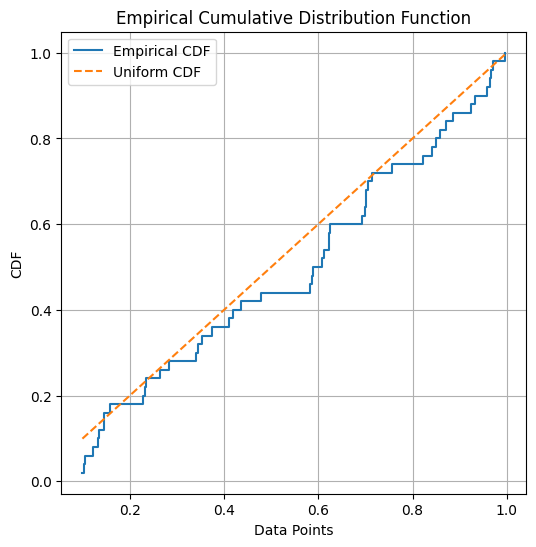

In [47]:
plot_ecdf(unif)